In [1]:
import pandas as pd
import numpy as np
import numpy.random as rgt

import matplotlib.pyplot as plt

In [2]:
class pADMM:
    '''
    pADMM: proximal ADMM algorithm for solving 
           weighted L1-penalized quantile regression

    Reference
    ---------
    ADMM for high-dimensional sparse penalized quantile regression (2018)
    by Yuwen Gu, Jun Fan, Lingchen Kong, Shiqian Ma and Hui Zou
    Technometrics 60(3): 319--331, DOI: 10.1080/00401706.2017.1345703
    '''
    opt = {'gamma': 1, 'max_iter': 5e3, 'tol': 1e-5, 'nsim': 200}


    def __init__(self, X, Y, intercept=True, options={}):
        '''
        Arguments
        ---------
        X : n by p matrix of covariates; each row is an observation vector.

        Y : n-dimensional vector of response variables.

        intercept : logical flag for adding an intercept to the model.

        options : a dictionary of internal optimization parameters.

        gamma : constant step length for the theta-step; default is 1.

        max_iter : maximum numder of iterations; default is 5e3.

        tol : tolerance level in the ADMM convergence criterion; default is 1e-5.

        nsim : number of simulations for computing a data-driven lambda; default is 200.
        '''
        self.n = len(Y)

        self.Y = Y.reshape(self.n)
        self.mX, self.sdX = np.mean(X, axis=0), np.std(X, axis=0)

        self.itcp = intercept
        if intercept:
            self.X = np.c_[np.ones(self.n), X]
            self.X1 = np.c_[np.ones(self.n), (X - self.mX)/self.sdX]
        else:
            self.X, self.X1 = X, X/self.sdX
        self.opt.update(options)


    def prox_map(self, x, tau, alpha):
        return x - np.maximum((tau - 1)/alpha, np.minimum(x, tau/alpha))


    def _eta(self):
        #return np.linalg.svd(self.X, compute_uv=0).max()**2
        return np.linalg.svd(self.X.T @ self.X, compute_uv=0).max()


    def l1(self, tau=0.5, Lambda=0.1, beta=np.array([]), 
           res=np.array([]), sigma=0.01, eta=None):
        '''
        Weighted L1-Penalized Quantile Regression 

        Arguments
        ---------
        tau : quantile level (between 0 and 1); default is 0.5.

        Lambda : regularization parameter. This should be either a scalar, or
                 a vector of length equal to the column dimension of X. 

        beta : initial estimator of slope coefficients. 
               If unspecified, it will be set as zero.

        res : residual vector of the initial estiamtor.

        sigma : augmentation parameter; default is 0.01.

        eta :  a positive parameter; 
               if unspecifed, it will be set as the largest eigenvalue of X'X.

        Returns
        -------
        'beta' : an ndarray of estimated coefficients.

        'res' : an ndarray of fitted residuals.

        'lambda' : regularization parameter.
        '''
        n, dim = self.n, self.X.shape[1]
        if not beta.any(): 
            beta, res = np.zeros(dim), self.Y
        z, theta = res, np.ones(n)/n
        if eta == None: eta = self._eta()

        if self.itcp:
            Lambda = np.insert(Lambda * np.ones(dim-1), 0, 0)

        k, dev = 0, 1
        while dev > self.opt['tol'] and k < self.opt['max_iter']:
            w = np.ones(p + 1) # 여기선 w = 1_p 로 두어 l1-penalized 
            beta_new = self.soft_thresh(beta + self.X.T.dot(theta/sigma + res - z) / eta, \
                                        (Lambda * w) / (sigma * eta))
                                        #Lambda / sigma / eta)
            res = self.Y - self.X.dot(beta_new)
            z = self.prox_map(res + theta/sigma, tau, n * sigma)
            theta = theta - self.opt['gamma'] * sigma * (z - res)

            dev = max(abs(beta_new - beta))
            beta = beta_new
            k += 1

        return {'beta': beta, 
                'res': res,
                'niter': k, 
                'theta': theta,
                'lambda': Lambda}


    def soft_thresh(self, x, c):
        tmp = abs(x) - c
        return np.sign(x)*np.where(tmp<=0, 0, tmp)


    def l1_path(self, tau=0.5, lambda_seq=np.array([]), nlambda=50,
            order="descend", sigma=0.1, eta=None):
        '''
        Solution Path of L1-Penalized Quantile Regression

        Arguments
        ---------
        tau : quantile level (between 0 and 1); default is 0.5.

        lambda_seq : an ndarray of lambda values (regularization parameters).

           nlambda : number of lambda values.

        order : a character string indicating the order of lambda values along 
                which the solution path is obtained; default is 'descend'.

        sigma : augmentation parameter; default is 0.01.

        eta :  a positive parameter; 
               if unspecifed, it will be set as the largest eigenvalue of X'X.

        Returns
        -------
        'beta_seq' : a sequence of l1-QR estimates.

        'res_seq' : a sequence of residual vectors. 

        'size_seq' : a sequence of numbers of selected variables. 

        'lambda_seq' : a sequence of lambda values in ascending/descending order.
        '''
        if len(lambda_seq) == 0:
            lam_max = max(self.self_tuning(tau, standardize=False))
            lambda_seq = np.linspace(0.25*lam_max, lam_max, num=nlambda)

        if order == 'ascend':
            lambda_seq = np.sort(lambda_seq)
        elif order == 'descend':
            lambda_seq = np.sort(lambda_seq)[::-1]
        nlambda = len(lambda_seq)

        if eta == None: eta = self._eta()

        beta_seq = np.zeros(shape=(self.X.shape[1], nlambda))
        res_seq = np.zeros(shape=(self.n, nlambda))

        niter_seq = np.ones(nlambda)
        model = self.l1(tau, lambda_seq[0], sigma=sigma, eta=eta)
        beta_seq[:,0], res_seq[:,0] = model['beta'], model['res']
        niter_seq[0] = model['niter']

        for l in range(1, nlambda):
            model = self.l1(tau, lambda_seq[l], beta_seq[:,l-1], 
                            res_seq[:,l-1], sigma=sigma, eta=eta)
            beta_seq[:,l], res_seq[:,l] = model['beta'], model['res']
            niter_seq[l] = model['niter']

        return {'beta_seq': beta_seq, 
                'res_seq': res_seq,
                'size_seq': np.sum(beta_seq[self.itcp:,:] != 0, axis=0),
                'lambda_seq': lambda_seq,
                'niter_seq': niter_seq}



    def self_tuning(self, tau=0.5, standardize=True):
        '''
        A Simulation-based Approach for Choosing the Penalty Level (Lambda)

        Reference
        ---------
        l1-Penalized quantile regression in high-dimensinoal sparse models (2011)
        by Alexandre Belloni and Victor Chernozhukov
        The Annals of Statistics 39(1): 82--130.

        Arguments
        ---------
        tau : quantile level; default is 0.5.

        standardize : logical flag for x variable standardization prior to fitting the model; 
                      default is TRUE.

        Returns
        -------
        lambda_sim : an ndarray of simulated lambda values.
        '''    
        if standardize: X = self.X1 
        else: X = self.X

        lambda_sim = np.array([max(abs(X.T.dot(tau - (rgt.uniform(0,1,self.n) <= tau))))
                               for b in range(self.opt['nsim'])])
        return lambda_sim/self.n

In [3]:
nlambda, M = 50, 100

In [4]:
p, n = 20, 100
tau = 0.5
itcp, true_beta = 1, np.zeros(p)
true_beta[:5] = [1.8, 1.6, 0, 0.5, 2]

X = rgt.normal(0, 1, size=(n,p))
Y = itcp + X.dot(true_beta) + rgt.normal(0, 0.2, size=n)

In [5]:
admm = pADMM(X, Y, intercept=True)
l1_model = admm.l1(tau=tau, Lambda=0.1)

In [6]:
l1_model

{'beta': array([ 0.9892093 ,  1.74833378,  1.55191981,  0.        ,  0.40064609,
         1.96861014, -0.        , -0.01452967,  0.        , -0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        -0.        ]),
 'res': array([ 1.23773130e-01, -7.47941539e-01,  5.17414465e-02, -1.92064488e-01,
         1.33398541e-01, -5.20984559e-02, -2.04968384e-01,  2.06187314e-02,
         2.29100694e-01,  2.67542530e-01,  3.07419935e-04,  8.51568051e-02,
        -4.97782495e-02, -1.79548522e-01,  3.95423369e-01,  4.98519092e-02,
         4.75325364e-01, -3.21499938e-02,  1.08842355e-01, -1.96090449e-01,
         4.82083374e-03,  4.22681738e-01,  1.49405772e-01, -2.43313333e-01,
         7.26948243e-02,  1.92461420e-01,  6.60417245e-02,  2.03125978e-01,
        -1.83558451e-01,  1.90285393e-01,  8.20120471e-02, -7.22700313e-02,
        -1.37126090e-01,  1.48262643e-01, -1.51017053e-01, -1.

In [7]:
true_beta = np.insert(true_beta, 0, 1)

In [8]:
est_beta = l1_model['beta']

In [9]:
pd.DataFrame(zip(true_beta, est_beta), columns=['true', 'estimated'])

,true,estimated
0,1.0,0.989209
1,1.8,1.748334
2,1.6,1.551920
3,0.0,0.000000
4,0.5,0.400646
5,2.0,1.968610
6,0.0,-0.000000
7,0.0,-0.014530
8,0.0,0.000000
9,0.0,-0.000000


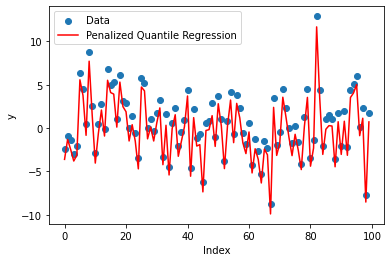

In [10]:
# weight = 1 (p-dim) 으로 두었을 때 
# lasso-penalized QR

plt.scatter(range(n), Y, label='Data')
plt.plot(range(n), X @ true_beta[1:], color='r', label='Penalized Quantile Regression')
plt.xlabel('Index')
plt.ylabel('y')
plt.legend()
plt.show()

---